In [1]:
import os
import sys
import glob
import warnings
from copy import deepcopy



import astropy.constants as apc
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy import stats
from scipy.stats import gaussian_kde, ks_2samp

PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'
sys.path.append(PROJECT_DIR)

from utils.astro import calc_T14_circ, jacobian, detection_prior, duration_ratio
from utils.eccsamp import imp_sample_rhostar, get_e_omega_obs_priors, calc_rho_star
from utils.io import load_dr25_data_from_hdf5, load_posteriors, extract_posteriors
from utils.stats import weighted_percentile, draw_random_samples

sys.path.append('/Users/research/projects/alderaan/')
from alderaan.Results import Results

pi = np.pi

RSAU = (apc.R_sun/apc.au).value                                 # solar radius [AU]
RSRE = (apc.R_sun/apc.R_earth).value                            # R_sun/R_earth
RHOSUN_GCM3 = (3*apc.M_sun/(4*pi*apc.R_sun**3)).value/1000      # solar density [g/cm^3]

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
colors = ['C4', 'C2', 'C0', 'C1', 'C3']
linestyles = ['-', '-', '--', ':']
titles = ['sub-Earths', 'super-Earths', 'sub-Neptunes', 'sub-Saturns', 'Jovians']

## Load H-Bayes Posteriors

In [3]:
PATHS = [os.path.join(PROJECT_DIR, 'Results/20241006/alderaan-all-LC-category5-empirical/'),
         os.path.join(PROJECT_DIR, 'Results/20241006/alderaan-all-LC-category5-beta/'),
         os.path.join(PROJECT_DIR, 'Results/20241006/alderaan-all-LC-category5-halfnormal/'),
         os.path.join(PROJECT_DIR, 'Results/20241006/alderaan-all-LC-category5-rayleigh/')
        ]

In [4]:
distributions = []

for path in PATHS:
    loc = path.find('category5') + 10
    distributions.append(path[loc:-1])

In [5]:
posteriors = {}

for i, dist in enumerate(distributions):
    # load H-Bayes posteriors
    files = list(np.sort(glob.glob(os.path.join(PATHS[i], '*.fits'))))
    
    samples, headers, bin_edges = load_posteriors(files)
    rp, ecc, mult, nobj = extract_posteriors(samples, headers)

    # store data in a dictionary
    posteriors[dist] = {}
    
    posteriors[dist]['samples'] = samples
    posteriors[dist]['header']  = headers
    posteriors[dist]['bin_edges'] = bin_edges
    posteriors[dist]['planet_count'] = nobj
    posteriors[dist]['multiplicity'] = mult

### AIC & BIC

In [6]:
for i, dist in enumerate(distributions):
    p = posteriors[dist]
    
    p['ln_like'] = np.zeros(len(p['samples']))
    p['aic'] = np.zeros(len(p['samples']))
    p['bic'] = np.zeros(len(p['samples']))
    
    for j, s in enumerate(p['samples']):
        n = p['planet_count'][j]
        k = (len(s.columns) - 104) // 2
        lnL = np.max(s.ln_like)
                
        p['ln_like'][j] = lnL
        p['aic'][j] = 2*k - 2*lnL
        p['bic'][j] = k*np.log(n) - 2*lnL

In [7]:
for i in range(5):
    
    print("\n{0}".format(titles[i]))
    
    print("  AIC:")
    for j, dist in enumerate(distributions):
        aic = posteriors[dist]['aic'][i]
        print("\t{0}: {1:.0f}".format(dist, aic))
        
    print("  BIC:")
    for j, dist in enumerate(distributions):
        bic = posteriors[dist]['bic'][i]
        print("\t{0}: {1:.0f}".format(dist, bic))


sub-Earths
  AIC:
	empirical: 813
	beta: 804
	halfnormal: 812
	rayleigh: 811
  BIC:
	empirical: 818
	beta: 809
	halfnormal: 815
	rayleigh: 814

super-Earths
  AIC:
	empirical: 4759
	beta: 4804
	halfnormal: 4810
	rayleigh: 4790
  BIC:
	empirical: 4768
	beta: 4812
	halfnormal: 4814
	rayleigh: 4794

sub-Neptunes
  AIC:
	empirical: 8619
	beta: 8633
	halfnormal: 8691
	rayleigh: 8706
  BIC:
	empirical: 8628
	beta: 8643
	halfnormal: 8696
	rayleigh: 8711

sub-Saturns
  AIC:
	empirical: 453
	beta: 460
	halfnormal: 470
	rayleigh: 485
  BIC:
	empirical: 457
	beta: 464
	halfnormal: 472
	rayleigh: 487

Jovians
  AIC:
	empirical: 380
	beta: 380
	halfnormal: 386
	rayleigh: 405
  BIC:
	empirical: 384
	beta: 384
	halfnormal: 388
	rayleigh: 407


In [8]:
for dist in distributions:
    print(dist)
    
    aic = np.mean(posteriors[dist]['aic'])
    print("  AIC: {0:.0f}".format(aic))

    bic = np.mean(posteriors[dist]['bic'])
    print("  BIC: {0:.0f}".format(bic))

empirical
  AIC: 3005
  BIC: 3011
beta
  AIC: 3016
  BIC: 3022
halfnormal
  AIC: 3034
  BIC: 3037
rayleigh
  AIC: 3039
  BIC: 3042


### Inferred model parameters

In [9]:
distributions

['empirical', 'beta', 'halfnormal', 'rayleigh']

In [10]:
var_names = {'empirical':('v','h'), 'beta':('a','b'), 'halfnormal':('sd'), 'rayleigh':('sd')}

for i in range(5):
    print("\n{0}".format(titles[i]))
    
    for j, dist in enumerate(distributions):
        print("  {0}:".format(dist))
       
        s = posteriors[dist]['samples'][i]
        
        
        for var in np.atleast_1d(var_names[dist]):
            val = np.percentile(s[var], [16,50,84])
            
            print("    {0} = {1:.2f} + {2:.2f} - {3:.2f}".format(var, val[1], val[2]-val[1], val[1]-val[0]))


sub-Earths
  empirical:
    v = 1.56 + 0.37 - 0.28
    h = 1.17 + 0.49 - 0.40
  beta:
    a = 1.13 + 2.55 - 0.50
    b = 24.63 + 42.76 - 12.66
  halfnormal:
    sd = 0.05 + 0.02 - 0.02
  rayleigh:
    sd = 0.02 + 0.02 - 0.01

super-Earths
  empirical:
    v = 1.65 + 0.33 - 0.22
    h = 0.86 + 0.24 - 0.18
  beta:
    a = 1.26 + 1.22 - 0.49
    b = 32.98 + 27.86 - 12.67
  halfnormal:
    sd = 0.05 + 0.01 - 0.01
  rayleigh:
    sd = 0.03 + 0.01 - 0.01

sub-Neptunes
  empirical:
    v = 1.10 + 0.07 - 0.06
    h = 0.97 + 0.20 - 0.16
  beta:
    a = 0.54 + 0.07 - 0.05
    b = 7.40 + 1.13 - 0.94
  halfnormal:
    sd = 0.11 + 0.01 - 0.01
  rayleigh:
    sd = 0.08 + 0.01 - 0.01

sub-Saturns
  empirical:
    v = 0.77 + 0.15 - 0.11
    h = 0.70 + 0.28 - 0.23
  beta:
    a = 0.36 + 0.10 - 0.07
    b = 2.31 + 0.79 - 0.62
  halfnormal:
    sd = 0.24 + 0.03 - 0.03
  rayleigh:
    sd = 0.17 + 0.02 - 0.02

Jovians
  empirical:
    v = 0.67 + 0.17 - 0.10
    h = 0.57 + 0.26 - 0.20
  beta:
    a = 0.49 

### Plots

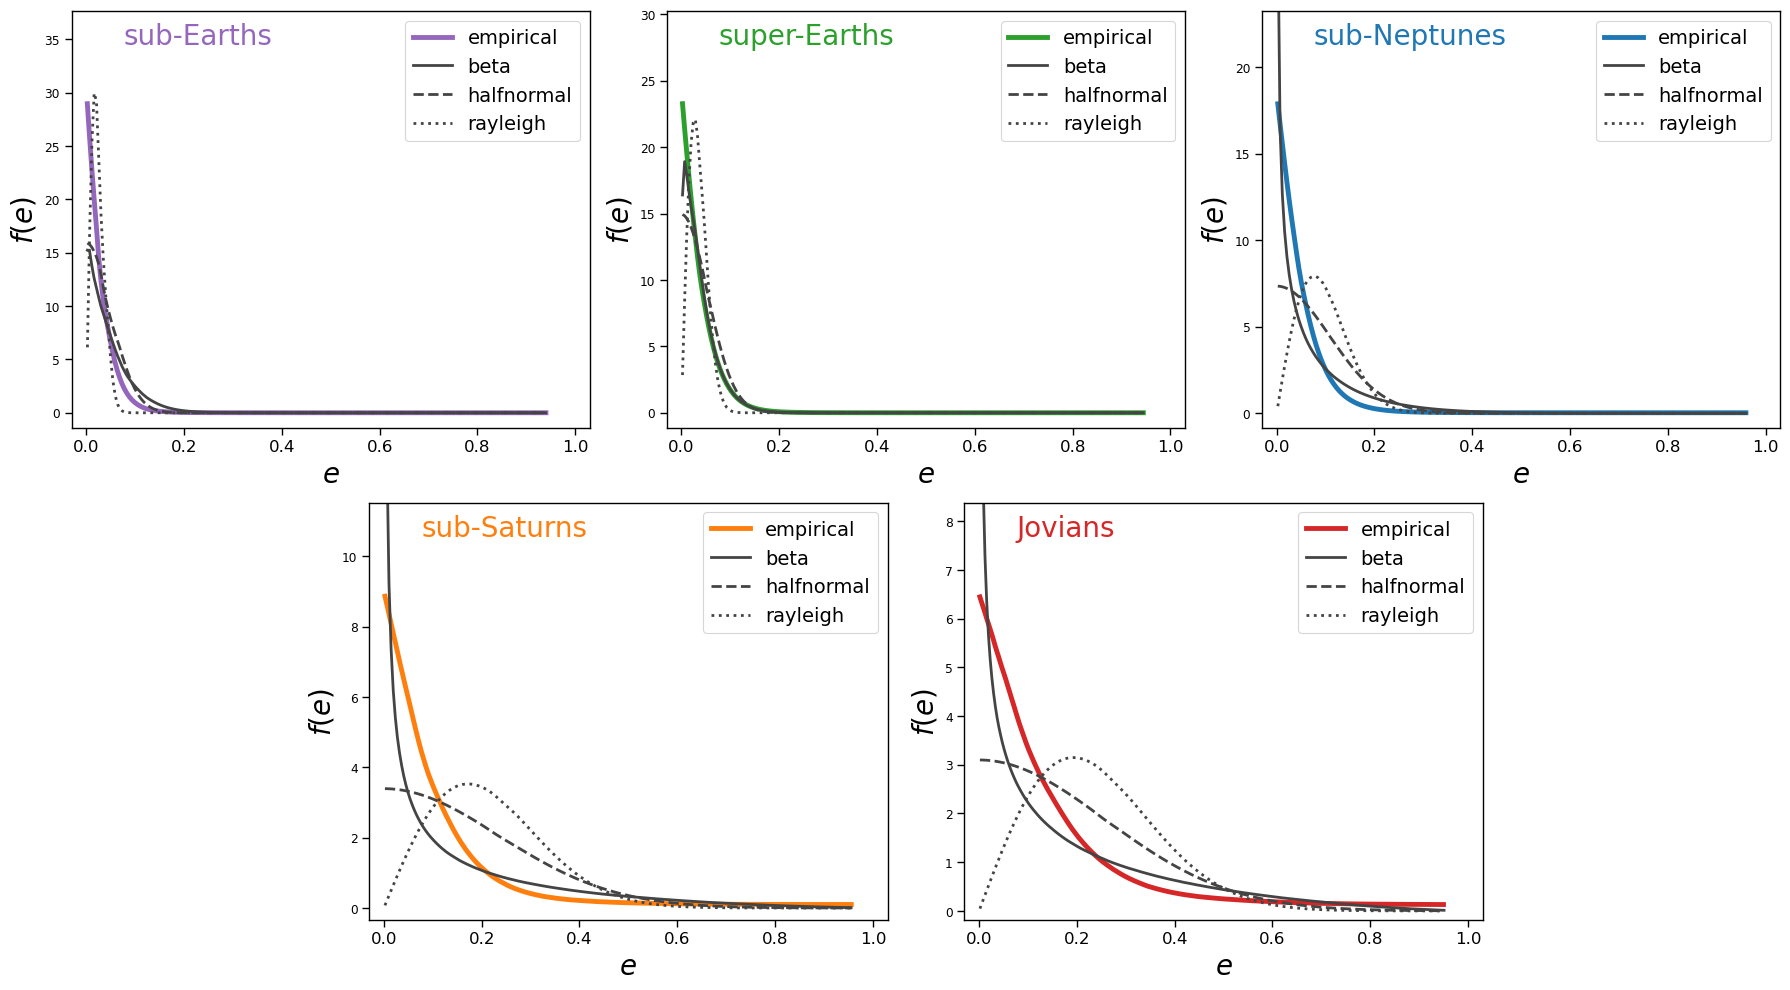

In [11]:
sns.set_context("paper")

fig = plt.figure(figsize=(18,10))
locs = [(0,0), (0,2), (0,4), (1,1), (1,3)]


for i in range(5):
    ax = plt.subplot2grid(shape=(2,6), loc=locs[i], rowspan=1, colspan=2)
    
           
           
    for j, dist in enumerate(distributions):
        p = posteriors[dist]
        s = p['samples'][i]
        
        bin_centers = 0.5*(p['bin_edges'][i][1:] + p['bin_edges'][i][:-1])
        
        ln_pdf = s.filter(regex='ln_pdf')
        ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)
        
        #lnL = s.ln_like 
        #pdf = np.exp(ln_pdf.iloc[s.ln_like.idxmax()])
        pdf = np.exp(np.median(ln_pdf, axis=0))

        if dist == 'empirical':
            ax.plot(bin_centers, pdf, color=colors[i], lw=3.5, label=dist)
            ax.set_xlim(-0.03,1.03)
            ax.set_ylim(None,1.3*pdf[0])
            
        else:
            ax.plot(bin_centers, pdf, color="#444444", ls=linestyles[j], lw=2, label=dist)
            

    ax.set_xlabel('$e$', fontsize=20)
    ax.set_ylabel('$f(e)$', fontsize=20)
    ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=12)
    #ax.set_yticks([])
    ax.text(0.1, 0.92, '{0}'.format(titles[i]), fontsize=20, color=colors[i], transform=ax.transAxes)
    ax.legend(fontsize=14)
    

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'Figures/model-compare-all.pdf'), bbox_inches='tight')
plt.show()

## Load transit data

In [12]:
DATA_SOURCE  = 'ALDERAAN'
DATA_DIR     = '/Users/research/projects/alderaan/Results/ecc-all-LC/'
NSAMP        = 1000
MULTIPLICITY = (1,99)
MSTAR_LIM    = (0.,10.)
RSTAR_LIM    = (0.7,1.4)
FEH_LIM      = (-0.5,0.5)
TEFF_LIM     = (4700,6500)
AGE_LIM      = (0,14)

#### Catalog

In [13]:
DR25_CATALOG = os.path.join(PROJECT_DIR, 'Catalogs/kepler_dr25_gaia_dr2_crossmatch.csv')
catalog = pd.read_csv(DR25_CATALOG, index_col=0)

# hard-code period and radius limits
use  = (catalog.period > 1) * (catalog.period < 100)
use *= (catalog.rp > 0.5) * (catalog.rp < 16)

# remove likely false positives
use *= (catalog.fpp < 0.1) + (catalog.disposition == 'CONFIRMED')

# clean up stellar sample
use *= catalog.logg > 4.0                                 # surface gravity as proxy for main sequence
use *= (catalog.rcf - 1 < 0.05) + np.isnan(catalog.rcf)   # radius correction factor (Furlan+ 2017)
use *= catalog.ruwe < 1.4                                 # Gaia RUWE

use *= ((catalog.mstar >= MSTAR_LIM[0]) &
        (catalog.mstar <= MSTAR_LIM[1]) &
        (catalog.rstar >= RSTAR_LIM[0]) &
        (catalog.rstar <= RSTAR_LIM[1]) &
        (catalog.feh >= FEH_LIM[0]) &
        (catalog.feh <= FEH_LIM[1]) &
        (catalog.teff >= TEFF_LIM[0]) &
        (catalog.teff <= TEFF_LIM[1]) &
        (catalog.age >= AGE_LIM[0]) &
        (catalog.age <= AGE_LIM[1])
       )

# cut on multiplicity
use *= ((catalog.npl >= MULTIPLICITY[0]) & (catalog.npl <= MULTIPLICITY[1]))
        
        
# update targets and catalog
catalog = catalog.loc[use].reset_index(drop=True)
targets = np.array(catalog.planet_name)

In [14]:
len(targets)

1649

#### Posterior chains

In [15]:
def infer_planet_koi_from_period(star_koi, P_samp, catalog):
    P_all = catalog.loc[catalog.koi_id==star_koi, 'period'].values
    P_cat = P_all[np.argmin(np.abs(P_all - P_samp))]
        
    return catalog.loc[catalog.period==P_cat, 'planet_name'].values[0]

In [16]:
def infer_index_from_planet_koi(planet_koi, results, catalog):
    periods = np.zeros(results.npl)

    for n in range(results.npl):
        periods[n] = np.median(results.samples(n).PERIOD)
    
    return np.argmin(np.abs(periods - catalog.loc[catalog.planet_name==planet_koi, 'period'].values))   

In [17]:
chains  = {}
failure = []

# read in the data
if DATA_SOURCE == 'DR25':
    CHAINS = os.path.join(DATA_DIR, 'dr25-chains_trimmed-thinned.hdf')

    for i, t in enumerate(targets):
        try:
            chains[t] = pd.DataFrame(load_dr25_data_from_hdf5(CHAINS, t))
            chains[t]['DUR14'] = calc_T14_circ(chains[t].PERIOD, chains[t].ROR, chains[t].IMPACT, chains[t].RHOTILDE)

            if np.any(chains[t].values < 0):
                raise ValueError("Negative values in posterior chain")
            if np.sum(np.isnan(chains[t].values)) > 0:
                raise ValueError("NaN values in posterior chain")

        except:
            #warnings.warn("{0} failed to load".format(t))
            failure.append(t)

        
# Alderaan analysis only configured for single-transiting systems
elif DATA_SOURCE == 'ALDERAAN':
    files = np.sort(glob.glob(os.path.join(DATA_DIR, '*/*results.fits')))
    
    for i, t in enumerate(targets):
        try:
            results = Results(t[:-3], DATA_DIR)
            n = infer_index_from_planet_koi(t, results, catalog)
            
            chains[t] = results.samples(n).sample(n=8000, replace=True, weights=results.posteriors.weights(), ignore_index=True)
            chains[t] = chains[t].drop(columns='LN_WT')
            
        except:
            #warnings.warn("{0} failed to load".format(t))
            failure.append(t)


else:
    raise ValueError("Data source must be either 'DR25' or 'ALDERAAN'")
    

# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets loaded".format(len(targets)))

1645 targets loaded


#### Sanitize chains

In [18]:
failure = []

if DATA_SOURCE == 'DR25':
    for i, t in enumerate(targets):
        # remove grazing transits
        if np.any(chains[t].IMPACT.values  > 1 - chains[t].ROR.values):
            failure.append(t)

        # eliminate NaN and zero-valued chains
        if np.any(chains[t].values < 0):
            failure.append(t)
        if np.sum(np.isnan(chains[t].values)) > 0:
            failure.append(t)

        # check Gelman-Rubin convergence statistic
        for k in chains[t].keys():
            Rhat = gelman_rubin(chains[t][k].values.reshape(4,-1))
            if Rhat > 1.05:
                failure.append(t)

        # check Hartigan dip test for multimodality
        for k in chains[t].keys():
            dip, pval = diptest.diptest(chains[t][k].values)
            if pval < 0.05:            
                failure.append(t)
                
                
grazing_fraction = []                
                
if DATA_SOURCE == 'ALDERAAN':
    for i, t in enumerate(targets):
        # remove grazing transits
        grazing = chains[t].IMPACT.values > 1 - chains[t].ROR.values
        
        grazing_fraction.append(np.sum(grazing)/len(grazing))

        if grazing_fraction[i] > 0.05:
            failure.append(t)

# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets found with unreliable chains".format(len(np.unique(failure))))

121 targets found with unreliable chains


#### Update transit parameters

In [19]:
catalog_keys = 'period epoch ror duration impact'.split()
samples_keys = 'PERIOD T0 ROR DUR14 IMPACT'.split()

for i, t in enumerate(targets):
    use = catalog.planet_name == t
    samples = chains[t]
    
    for j, ck in enumerate(catalog_keys):
        sk = samples_keys[j]

        catalog.loc[use, ck] = np.median(samples[sk])
        catalog.loc[use, ck+'_err1'] = np.percentile(samples[sk], 84) - catalog.loc[use, ck]
        catalog.loc[use, ck+'_err2'] = np.percentile(samples[sk], 16) - catalog.loc[use, ck]

#### Calculate self-consistent planet radii

In [20]:
ror = catalog.ror
ror_err = np.sqrt(catalog.ror_err1**2 + catalog.ror_err2**2)/np.sqrt(2)

Rstar = catalog.rstar
Rstar_err = np.sqrt(catalog.rstar_err1**2 + catalog.rstar_err2**2)/np.sqrt(2)

# radius gap location from Petigura+2022; R = R0*(P/10)^y, R0 = 1.84 +/- 0.03, y = 0.11 +/- 0.02
catalog['rgap'] = np.array(1.84*(catalog.period/10)**-0.11)
catalog['rgap_err'] = catalog.rgap * np.sqrt( 0.02**2*np.log(catalog.period/10)**2 + (0.03/1.84)**2)

# physical planet radius
catalog['rp'] = np.array(ror*Rstar*RSRE)
catalog['rp_err'] = np.array(catalog.rp * np.sqrt((ror_err/ror)**2 + (Rstar_err/Rstar)**2))

# radius corrected to P=10 days (see Ho & Van Eylen 2023); equivalent to using diagonal bins
catalog['rp10'] = np.exp(np.log(catalog.rp) - np.log(catalog.rgap) + np.log(1.84))
catalog['rp10_err'] = np.sqrt(catalog.rp_err**2 + catalog.rgap_err**2)

# radius adjusted for super-Earths and sub-Neptunes only
rp = catalog.rp
rgap = catalog.rgap
rp_adj = np.array(rp)

rp_lower_lim = 1.0
rp_gap10_loc = 1.84
rp_giant_lim = 4.0

SE = (rp >= rp_lower_lim)*(rp < rgap)
SN = (rp >= rgap)*(rp < rp_giant_lim)
GP = (rp >= rp_giant_lim)

rp_adj[SE] = ((rp - rp_lower_lim)/(rgap - rp_lower_lim) * (rp_gap10_loc - rp_lower_lim) + rp_lower_lim)[SE]
rp_adj[SN] = ((rp - rgap)/(rp_giant_lim - rgap) * (rp_giant_lim - rp_gap10_loc) + rp_gap10_loc)[SN]
rp_adj[GP] = rp[GP]

rp_adj_err = np.copy(catalog['rp_err'])
rp_adj_err[SE+SN] = np.array(catalog['rp10_err'])[SE+SN]

catalog['rpadj'] = rp_adj
catalog['rpadj_err'] = rp_adj_err


# require better than 20% precision on radius
use = catalog.rp_err/catalog.rp < 0.2

catalog = catalog.loc[use].reset_index(drop=True)
targets = np.array(catalog.planet_name)

#### Grab stellar densities

In [21]:
density = {}
failure = []

for i, t in enumerate(targets):
    try:
        use = catalog.planet_name == t
        
        rho_mu = catalog.loc[use, 'rhostar'].iloc[0]
        rho_err1 = np.abs(catalog.loc[use, 'rhostar_err1'].iloc[0])
        rho_err2 = np.abs(catalog.loc[use, 'rhostar_err2'].iloc[0])

        # don't use highly asymmetric density constraints
        if np.abs(rho_err1-rho_err2)/(0.5*(rho_err1+rho_err2)) > 0.30:
            failure.append(t)
        else:
            density[t] = rho_mu, np.sqrt(rho_err1**2 + rho_err2**2)/np.sqrt(2)
    
    except:
        warnings.warn("{0} has no recorded density".format(t))
        failure.append(t)

        
# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

print("{0} targets found with missing or unreliable densities".format(len(np.unique(failure))))

6 targets found with missing or unreliable densities


In [22]:
# track samples of true density and pseudo-density
rhosamp_true = {}
rhosamp_pseudo = {}

for i, t in enumerate(targets):
    c = chains[t]
    
    rhosamp_true[t] = stats.norm(1.41*density[t][0], 1.41*density[t][1]).rvs(size=len(c.DUR14))
    rhosamp_pseudo[t] = calc_rho_star(c.PERIOD, c.DUR14, c.IMPACT, c.ROR, 0., 0.)

## Importance sample

In [23]:
data = {}
failure = []

for i, t in enumerate(targets):
    try:
        # true stellar density (tuple) in g/cm3
        rho_true = 1.41*density[t][0], 1.41*density[t][1]

        w, d = imp_sample_rhostar(chains[t], rho_true, ew_obs_prior=False, upsample=500)
        d = d.sample(n=NSAMP, replace=True, weights=w, ignore_index=True)

        if DATA_SOURCE == 'DR25':
            J = jacobian(d.PERIOD, d.ROR, d.IMPACT, d.DUR14)
            d = d.sample(n=NSAMP, replace=True, weights=1/np.abs(J), ignore_index=True)

        data[t] = d

    except:
        warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
        failure.append(t)

    
# update targets and catalog
targets = list(np.array(targets)[~np.isin(targets,failure)])
catalog = catalog.loc[np.isin(catalog.planet_name, targets)].reset_index(drop=True)

/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/4149365461.py:19: UserWarning: K00891.01 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/4149365461.py:19: UserWarning: K01204.01 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))
/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/4149365461.py:19: UserWarning: K02369.03 failed during sampling and will not be included in the analysis
  warnings.warn("{0} failed during sampling and will not be included in the analysis".format(t))


## Duration ratio plot

In [24]:
def ks16(x):
    return (1-x**2)**0.25

#### Observations from Kepler

In [25]:
rpadj_bins = np.array([0.5, 1.0, 1.84, 4.0, 8.0, 16.0])

dur_ratio_obs = []
dur_error_obs = []

rho_ratio_obs = []
rho_error_obs = []

for i in range(5):
    dur_ratio_obs.append([])
    dur_error_obs.append([])
    
    rho_ratio_obs.append([])
    rho_error_obs.append([])
    
    for j, t in enumerate(targets):
        use = np.array(catalog.planet_name) == t
        rpadj = catalog.loc[use, 'rpadj'].iloc[0]

        if (rpadj >= rpadj_bins[i])*(rpadj <= rpadj_bins[i+1]):
            T = data[t].DUR14

            period_  = stats.norm(np.mean(data[t].PERIOD), np.std(data[t].PERIOD)).rvs(size=len(T))
            ror_     = stats.norm(np.mean(data[t].ROR), np.std(data[t].ROR)).rvs(size=len(T))
            rhostar_ = stats.norm(1.41*density[t][0], 1.41*density[t][1]).rvs(size=len(T))
            
            T0 = calc_T14_circ(period_, ror_, 0., rhostar_)
            
            dur_ratio_obs[i].append(T/T0)
            dur_error_obs[i].append(np.std(data[t].DUR14)/np.mean(data[t].DUR14))
            
            rho_ratio_obs[i].append(rhosamp_pseudo[t]/rhosamp_true[t])
            rho_error_obs[i].append(np.std(rhosamp_pseudo[t])/np.mean(rhosamp_pseudo[t]))

    dur_ratio_obs[i] = np.array(dur_ratio_obs[i])
    dur_error_obs[i] = np.array(dur_error_obs[i])
    
    rho_ratio_obs[i] = np.array(rho_ratio_obs[i])
    rho_error_obs[i] = np.array(rho_error_obs[i])

#### Forward modeled predictions from parametric distributions

In [26]:
dur_ratio_pred = {}

b_samples = draw_random_samples(ks16, (0,1), int(1e4))
e_samples, om_samples = get_e_omega_obs_priors(int(1e4), 0.99)

random_draws = pd.DataFrame({"impact":b_samples, "ecc":e_samples, "omega":om_samples})


for dist in distributions:
    print(dist)
    
    dur_ratio_pred[dist] = []

    for i in range(5):
        dur_ratio = []
        rho_ratio = []
        
        npl, ndraw = np.shape(dur_ratio_obs[i])
        
        p = posteriors[dist]
        s = p['samples'][i]
        
        bin_centers = 0.5*(p['bin_edges'][i][1:] + p['bin_edges'][i][:-1])
        
        ln_pdf = s.filter(regex='ln_pdf')
        ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1).values
        
        
        for j in range(ndraw):
            # draw samples
            spline = CubicSpline(bin_centers, ln_pdf[j], bc_type='natural')    
            s_ = random_draws.sample(n=npl, replace=True, weights=np.exp(spline(random_draws.ecc)), ignore_index=True)
    
            # predicted duration ratio
            dr_samples = np.sqrt(1-s_.impact**2) * np.sqrt(1-s_.ecc**2)/(1+s_.ecc*np.sin(s_.omega))
            dr_samples = np.random.choice(dr_samples, size=npl) + np.median(dur_error_obs[i])*np.random.normal(0,1,size=npl)
            
            dur_ratio.append(np.copy(dr_samples))
            
        dur_ratio_pred[dist].append(np.array(dur_ratio).T)

empirical
beta
halfnormal
rayleigh


In [27]:
import scipy.optimize as op
from scipy.stats import ks_2samp

def ad_2samp(x1, x2):
    A, cv, p = stats.anderson_ksamp([x1, x2])

    alpha = np.array([0.25, 0.10, 0.05, 0.025, 0.01, 0.005, 0.001])
    
    res_fxn = lambda theta, x, y: y - 1/(1 + theta[0]*np.exp(x/theta[1]))
    
    fit, success = op.leastsq(res_fxn, [0.25, 1], args=(cv, alpha))
    
    z = np.linspace(-2,6)
    p_new = 1/(1 + fit[0]*np.exp(A/fit[1]))
    
    return A, p_new

In [28]:
ks_pval = {}
ad_pval = {}

for dist in distributions:
    ks_pval[dist] = []
    ad_pval[dist] = []

    for i in range(5):
        dr_obs = dur_ratio_obs[i]
        dr_pred = dur_ratio_pred[dist][i]

        # number of planets and draws
        npl, ndraw = np.shape(dr_obs)
        
        # track KS and AD tests
        ks = np.zeros(ndraw)
        ad = np.zeros(ndraw)

        for j in range(ndraw):
            ks[j] = ks_2samp(dr_obs[:,j], dr_pred[:,j])[1]
            ad[j] = ad_2samp(dr_obs[:,j], dr_pred[:,j])[1]

        ks_pval[dist].append(np.copy(ks))
        ad_pval[dist].append(np.copy(ad))

/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/351637095.py:5: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])
/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/351637095.py:5: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])


In [29]:
for i in range(5):
    print(titles[i], np.percentile(dur_ratio_obs[i], [0.5, 99.5]).round(3))

sub-Earths [0.404 1.3  ]
super-Earths [0.388 1.191]
sub-Neptunes [0.298 1.304]
sub-Saturns [0.301 1.202]
Jovians [0.361 1.147]


#### PDFs

In [31]:
NSAMP

1000

empirical


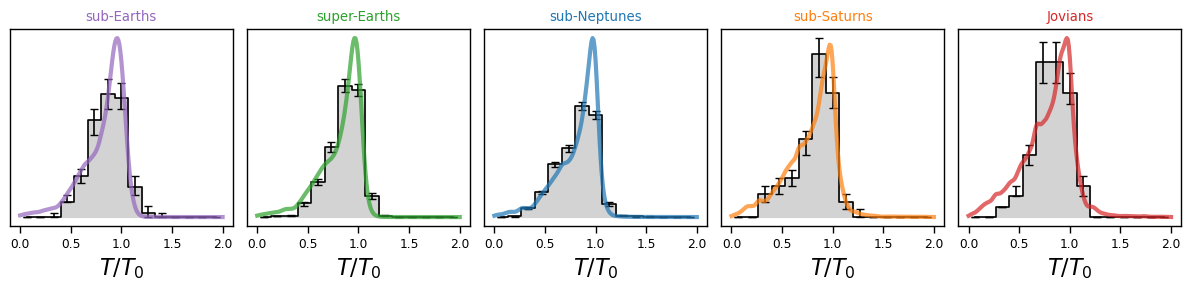

beta


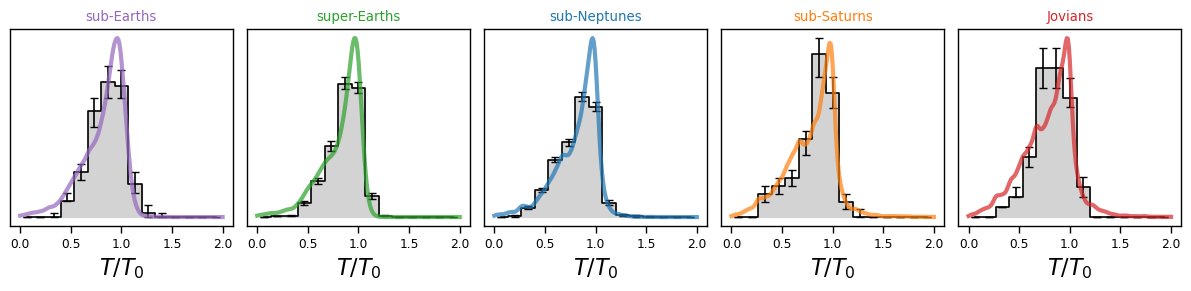

halfnormal


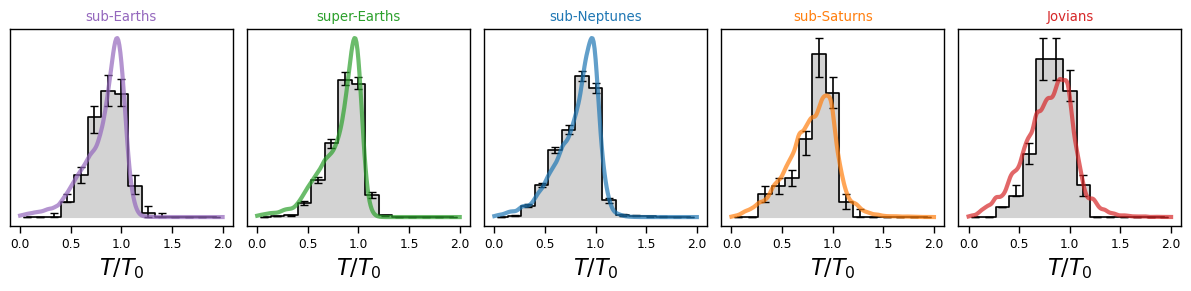

rayleigh


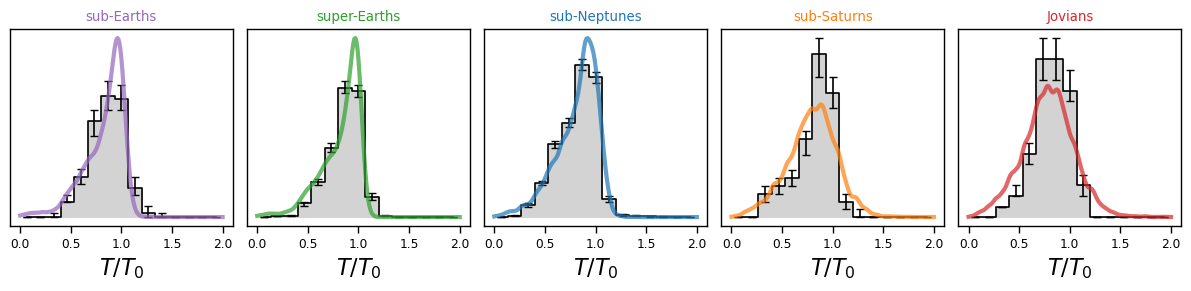

In [40]:
Nbin = 15
bin_edges = np.linspace(0,2,Nbin+1)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])

dr_obs_hist = np.zeros((5, NSAMP, Nbin), dtype='float')
for i in range(5):
    for j in range(NSAMP):
        dr_obs_hist[i,j] = np.histogram(dur_ratio_obs[i][:,j], bins=Nbin, range=(0,2), density=True)[0]


colors = ['C4', 'C2', 'C0', 'C1', 'C3']
titles = ['sub-Earths', 'super-Earths', 'sub-Neptunes', 'sub-Saturns', 'Jovians']

for dist in distributions:
    print(dist)
    
    fig, ax = plt.subplots(1,5, figsize=(12,3))
    
    for i in range(5):
        dr_pred = dur_ratio_pred[dist][i].flatten()
        kde_x   = np.linspace(0,2,201)
        kde_y   = gaussian_kde(dr_pred, bw_method=0.1)(kde_x)
    
        hist_x = bin_centers        
        hist_y = np.percentile(dr_obs_hist[i], [16,50,84], axis=0)
        hist_yerr = np.abs(np.array([hist_y[0], hist_y[2]]) - hist_y[1])
            
        ax[i].step(hist_x, hist_y[1], where='mid', color='k')
        ax[i].fill_between(hist_x, hist_y[1], step='mid', color='lightgrey')
        ax[i].errorbar(hist_x, hist_y[1], yerr=hist_yerr, fmt='none', capsize=3, color='k')
        
        ax[i].plot(kde_x, kde_y, color=colors[i], lw=3, alpha=0.7)
        ax[i].set_xlabel("$T/T_0$", fontsize=16)
        #ax[i].set_ylim(None, 1.5*kde_y.max())
        ax[i].set_yticks([])
        ax[i].set_title(titles[i], color=colors[i])
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/duration-ratio-check-{0}.pdf'.format(dist)), bbox_inches='tight')
    plt.show()

/var/folders/f5/94803ccd3kl1b6yw01k2zj0m0000gn/T/ipykernel_2372/1706782337.py:25: RuntimeWarning: invalid value encountered in log10
  percs = np.nanpercentile(np.log10(rho_ratio_obs[i]), [16,50,84])


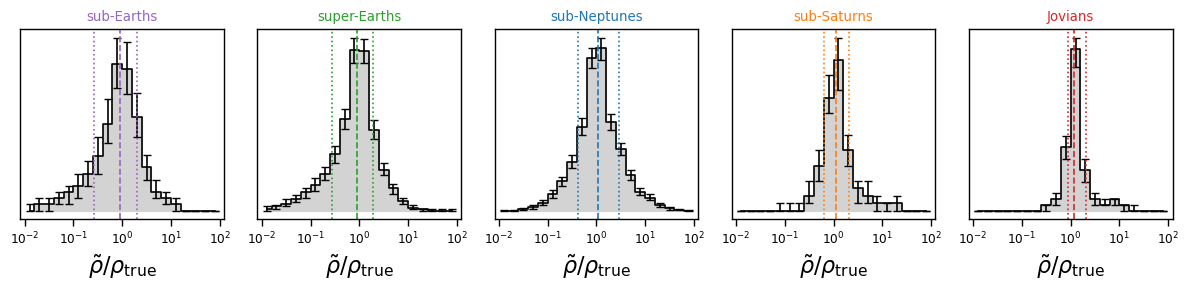

In [44]:
Nbin = 20
bin_edges = np.linspace(-2,2,Nbin+1)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])

lrr_obs_hist = np.zeros((5, NSAMP, Nbin), dtype='float')
for i in range(5):
    for j in range(NSAMP):
        lrr_obs_hist[i,j] = np.histogram(np.log10(rho_ratio_obs[i][:,j]), bins=Nbin, range=(-2,2), density=True)[0]


colors = ['C4', 'C2', 'C0', 'C1', 'C3']
titles = ['sub-Earths', 'super-Earths', 'sub-Neptunes', 'sub-Saturns', 'Jovians']

fig, ax = plt.subplots(1,5, figsize=(12,3))

for i in range(5):
    hist_x = bin_centers
    hist_y = np.percentile(lrr_obs_hist[i], [16,50,84], axis=0)
    hist_yerr = np.abs(np.array([hist_y[0], hist_y[2]]) - hist_y[1])

    ax[i].step(hist_x, hist_y[1], where='mid', color='k')
    ax[i].fill_between(hist_x, hist_y[1], step='mid', color='lightgrey')
    ax[i].errorbar(hist_x, hist_y[1], yerr=hist_yerr, fmt='none', capsize=3, color='k')

    percs = np.nanpercentile(np.log10(rho_ratio_obs[i]), [16,50,84])
    
    ax[i].axvline(percs[0], ls=':', color=colors[i])
    ax[i].axvline(percs[1], ls='--', color=colors[i])
    ax[i].axvline(percs[2], ls=':', color=colors[i])
    
    ax[i].set_xlabel(r"$\tilde{\rho}/\rho_{\rm true}$", fontsize=16)
    ax[i].set_xticks([-2,-1,0,1,2], [r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i], color=colors[i])

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'Figures/pseudodensity-ratio-check.pdf'), bbox_inches='tight')
plt.show()

#### CDFs

In [ ]:
colors = ['C4', 'C2', 'C0', 'C1', 'C3']
titles = ['sub-Earths', 'super-Earths', 'sub-Neptunes', 'sub-Saturns', 'Jovians']

fig, ax = plt.subplots(1,5, figsize=(20,5), rasterized=True)

for i in range(5):
    # distributions
    _obs = np.sort(dur_ratio_obs[i].flatten())
    _obs = np.hstack([0, _obs, np.max([_obs.max(),3.2])])

    _emp = np.sort(dur_ratio_pred['empirical'][i].flatten())
    _emp = np.hstack([0, _emp, np.max([_emp.max(),3.2])])

    _beta = np.sort(dur_ratio_pred['beta'][i].flatten())
    _beta = np.hstack([0, _beta, np.max([_beta.max(),3.2])])

    _norm = np.sort(dur_ratio_pred['halfnormal'][i].flatten())
    _norm = np.hstack([0, _norm, np.max([_norm.max(),3.2])])

    _ray = np.sort(dur_ratio_pred['rayleigh'][i].flatten())
    _ray = np.hstack([0, _ray, np.max([_ray.max(),3.2])])

    # Anderson-Darling & Kolmogorov-Smirnov tests
    ad_lim = {}
    ks_lim = {}

    for d in distributions:
        ad_lim[d] = np.percentile(ad_pval[d][i], 90).round(3)
        ad_lim[d] = np.max([ad_lim[d], 0.001])

        ks_lim[d] = np.percentile(ks_pval[d][i], 90).round(3)
        ks_lim[d] = np.max([ks_lim[d], 0.001])

    # labels
    label_beta = "Beta"        + "\n  $p_{AD}$ < " + "{0:.3f}".format(ad_lim['beta']) + "\n  $p_{KS}$ < " + "{0:.3f}".format(ks_lim['beta'])
    label_norm = "Half-Normal" + "\n  $p_{AD}$ < " + "{0:.3f}".format(ad_lim['halfnormal']) + "\n  $p_{KS}$ < " + "{0:.3f}".format(ks_lim['halfnormal'])
    label_ray  = "Rayleigh"    + "\n  $p_{AD}$ < " + "{0:.3f}".format(ad_lim['rayleigh']) + "\n  $p_{KS}$ < " + "{0:.3f}".format(ks_lim['rayleigh'])

    # figure
    ax[i].fill_between(_obs,  np.linspace(0,1,len(_obs)),  step='pre', color='#ddd')
    ax[i].step(_emp,  np.linspace(0,1,len(_emp)),  where='pre', color=colors[i], lw=3)
    ax[i].step(_beta, np.linspace(0,1,len(_beta)), where='pre', color='k', ls='-', label=label_beta)
    ax[i].step(_norm, np.linspace(0,1,len(_norm)), where='pre', color='k', ls='--', label=label_norm)
    ax[i].step(_ray,  np.linspace(0,1,len(_ray)),  where='pre',  color='k', ls=':', label=label_ray)

    ax[i].set_xscale('log')
    ax[i].set_xlim(0.1,3.2)
    ax[i].set_xticks([0.1, 0.2, 0.4, 0.8, 1.6, 3.2], [0.1, 0.2, 0.4, 0.8, 1.6, 3.2])
    ax[i].set_ylim(0, None)
    ax[i].minorticks_off()
    ax[i].axvline(1.0, color='k', ls=':', alpha=0.5)
    ax[i].grid(ls=':')

    ax[i].set_title(titles[i], fontsize=18, color=colors[i])
    ax[i].set_xlabel("$T/T_0$", fontsize=16)
    ax[i].set_ylabel("CDF", fontsize=16)
    ax[i].legend(loc=(0.025,0.35), framealpha=1)
    ax[i].text(0.115, 0.95, "Models", fontsize=12, weight='bold')
    ax[i].text(0.115, 0.29, "Empirical", fontsize=12, color=colors[i], weight='bold')
    ax[i].plot(np.linspace(0.115, 0.32, 3), 0.27*np.ones(3), color=colors[i], lw=3)
    ax[i].text(0.13, 0.21, "$p_{AD}$ < " + "{0:.3f}".format(ad_lim['empirical']), color=colors[i])
    ax[i].text(0.13, 0.15, "$p_{KS}$ < " + "{0:.3f}".format(ks_lim['empirical']), color=colors[i])
    ax[i].text(3.1, 0.02, "Observations", ha='right', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, "Figures/cdf_comparison.pdf"), bbox_inches='tight')
plt.show()